In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix



import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [4]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())

/workspace/slp_jaspar/autoencoder/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


In [5]:
dataset.dataset.head()

,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


In [6]:
labels_order =  dataset.number_of_segments_per_game(60,5000)
print(labels_order)
labels_order = labels_order['Label'].values


             Label   Count   Shift
0              FOX  103069  193497
1            FALCO   90717  168117
2            MARTH   53728  106569
3   CAPTAIN_FALCON   38006   70125
4            SHEIK   27623   59145
5            PEACH   17438   39398
6       JIGGLYPUFF   16374   35581
7            SAMUS    9524   23031
8     ICE_CLIMBERS    6849   15620
9        GANONDORF    6655   12805
10           YOSHI    5725   12226
11           LUIGI    5230   11464
12        DR_MARIO    4202    9062
13         PIKACHU    4096    8991
14            LINK    2502    5598
15            NESS    2306    5812
16     DONKEY_KONG    2026    4333
17  GAME_AND_WATCH    1967    3693
18          MEWTWO    1775    4511
19           MARIO    1713    3824
20      YOUNG_LINK    1447    3278
21             ROY    1272    2685
22          BOWSER     940    2196
23           KIRBY     556    1237
24           PICHU     230     491


In [7]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  public\FALCO\bee06d45-fca6-437f-969a-901efa166...   28801             1   
1  mango\FALCO\44e0962b-fdf7-4a16-acbe-61b5e5d609...   27200             1   
2  ranked\FALCO\2f51bb81-4304-4c6d-ac53-960aba87c...   26024             1   
3  ranked\FALCO\69cf9bb4-5f80-4e67-850d-ce0d7da1d...   25128             1   
4  ranked\FALCO\04257d15-f02f-4001-a191-37b97d2ed...   24323             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [8]:
# train_df, test_df = dataset.all_segments_train_test_split_dataframes(60, proportion_of_segments=.01, test_ratio = .20, val = False)

In [9]:
print(train_df.shape)
print(test_df.shape)
print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))

(100000, 6)
(25000, 6)
0.2


In [10]:
train_df.head()

,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
0,mango\FALCO\b3c63d9d-efb7-4544-bdd6-9da7e221f1...,FALCO,4,0,0,60
1,mango\FALCO\a24ef3f0-ab56-47e6-af18-5905aa43af...,FALCO,4,0,0,60
2,mango\FALCO\24b523a3-18da-4ba2-a986-d0c99b6228...,FALCO,4,0,0,60
3,mango\FALCO\60e0d81b-e0bd-420c-8fce-fe2b11645c...,FALCO,4,0,0,60
4,public\FALCO\b0925bbb-c009-49db-80e6-6985d4756...,FALCO,4,0,0,60


In [11]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)
    

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)

        if self.transform:
            segment = self.transform(segment)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(segment[:,segment_start:segment_end]).float()
        # label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor#, label_tensor
    
def prepare_data_loaders(train_df, test_df, batch_size, num_workers):
    # Initialize datasets
    train_dataset = TrainingDataset(train_df)
    # val_dataset = TrainingDataset(file_paths_val, labels_val)
    test_dataset = TrainingDataset(test_df)

    # Initialize data loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True,persistent_workers=True),
        'test': DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True),
        # 'val': DataLoader(val_dataset, batch_size=2**9, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True)
    }
    return loaders



# ''' Get a batch of data to see the size if we want that information. ''' 
# data_loader_iterator = iter(loaders['train'])
# first_batch = next(data_loader_iterator)
# print(first_batch.shape)



In [12]:
def train_model(model, criterion, optimizer, loaders, device, num_epochs=1):
    scaler = GradScaler()  # Initialize the gradient scaler

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        total = 0
        i = 3
        for batch_number, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            
            # Resets the optimizer
            optimizer.zero_grad()
            
            # Runs the forward pass with autocasting.
            with autocast():
                output_gpu = model(target_gpu)
                loss = criterion(output_gpu, target_gpu)
                # print(loss)
            
            # Scales loss and calls backward() to create scaled gradients
            scaler.scale(loss).backward()
            
            # Clip gradients to avoid explosion
            scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Before calling step(), check for inf or NaN values in the gradients
            if any(torch.isinf(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: inf values in gradients!")
            elif any( torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: NaN values in gradients!")
                
            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)
            
            # Updates the scale for next iteration.
            scaler.update()

            # Update progress
            train_loss += loss.item()
            total += target_gpu.size(0)
            train_loader_tqdm.set_postfix(loss=f'{train_loss / (total):.4f}')
            # i += 1
            # if i > 10:
            #     break


def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu).item()
            total += target_gpu.size(0)
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (total):.4f}') 
            
    print(f'Evaluated Loss: {eval_loss / total:.6f}')
    

In [13]:
from ResNet_Autoencoder_Model import ResNet_Autoencoder

# Build model
model = ResNet_Autoencoder().to('cuda')

# With the size of an input we can get a model summary.
summary(model, input_size=(9, 60))

# Check that the output shape and target shape match
# training_example = torch.rand(9, 2 ** 12).to('cuda')
# print('Target shape:', training_example.shape)
# model.eval()
# output = model(training_example)
# print('Output shape:', output.shape)

## Optionally compile the model
# import torch_tensorrt
# model = torch.compile(model, mode = 'default')
# model = torch.compile(model,mode = 'max-autotune')
# model = torch.compile(model, backend="torch_tensorrt")
# model = torch.compile(model, backend="torch_tensorrt",mode = 'max-autotune')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 60]             640
       BatchNorm1d-2               [-1, 64, 60]             128
              ReLU-3               [-1, 64, 60]               0
            Conv1d-4               [-1, 64, 60]          12,352
       BatchNorm1d-5               [-1, 64, 60]             128
              ReLU-6               [-1, 64, 60]               0
            Conv1d-7              [-1, 256, 60]          16,640
       BatchNorm1d-8              [-1, 256, 60]             512
            Conv1d-9              [-1, 256, 60]           2,560
      BatchNorm1d-10              [-1, 256, 60]             512
             ReLU-11              [-1, 256, 60]               0
Encoder_Bottleneck-12              [-1, 256, 60]               0
           Conv1d-13               [-1, 64, 60]          16,448
      BatchNorm1d-14               [-1

In [14]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

torch.autograd.set_detect_anomaly(False)
# Pepare data loaders
batch_size =  32 * 16 * 5 
batch_size =  32 
num_workers = 22
loaders = prepare_data_loaders(train_df, test_df, batch_size, num_workers)

criterion = nn.MSELoss(reduction = 'sum')
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 1

# # # This seems to sometimes help
# gc.collect()
# torch.cuda.empty_cache()
# Train the model
# start_time = time.time()
train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# print(f'Batch Size: {batch_size}, Training time: {time.time() - start_time:.2f}')

# Again, this sometimes seems to help
# gc.collect()
# torch.cuda.empty_cache()

# Evaluate the trained model
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

Epoch 1/1:   0%|          | 5/3125 [00:01<07:50,  6.63batch/s, loss=647.6811]

Epoch 1/1:   0%|          | 13/3125 [00:01<03:07, 16.64batch/s, loss=651.9893]

Epoch 1/1:   1%|          | 21/3125 [00:01<02:05, 24.68batch/s, loss=653.4220]

Epoch 1/1: 100%|██████████| 3125/3125 [02:06<00:00, 24.66batch/s, loss=36.4834]


In [66]:
def predict(model, loaders, loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit='batch')
        
        for _, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            predictions.append(output_gpu.cpu().numpy())
            targets.append(target_cpu.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    return predictions, targets

In [125]:
pred, target = predict(model, loaders, 'test','cuda')

100%|██████████| 782/782 [00:04<00:00, 184.08batch/s]


In [18]:
evaluate_model(model, criterion, loaders, 'test', 'cuda')

100%|██████████| 782/782 [00:05<00:00, 156.25batch/s, loss=23.4053]

Evaluated Loss: 23.405268


In [72]:
print(type(pred))
print(pred.shape)
print(type(target))
print(target.shape)

<class 'numpy.ndarray'>
(25000, 9, 60)
<class 'numpy.ndarray'>
(25000, 9, 60)


Predictions JSTICK_X max: 0.9442932605743408, min: -0.9692184329032898
Predictions JSTICK_Y max: 1.0637612342834473, min: -1.036635398864746
Predictions CSTICK_X max: 1.108662486076355, min: -1.012547254562378
Predictions CSTICK_Y max: 1.0574581623077393, min: -1.0476429462432861


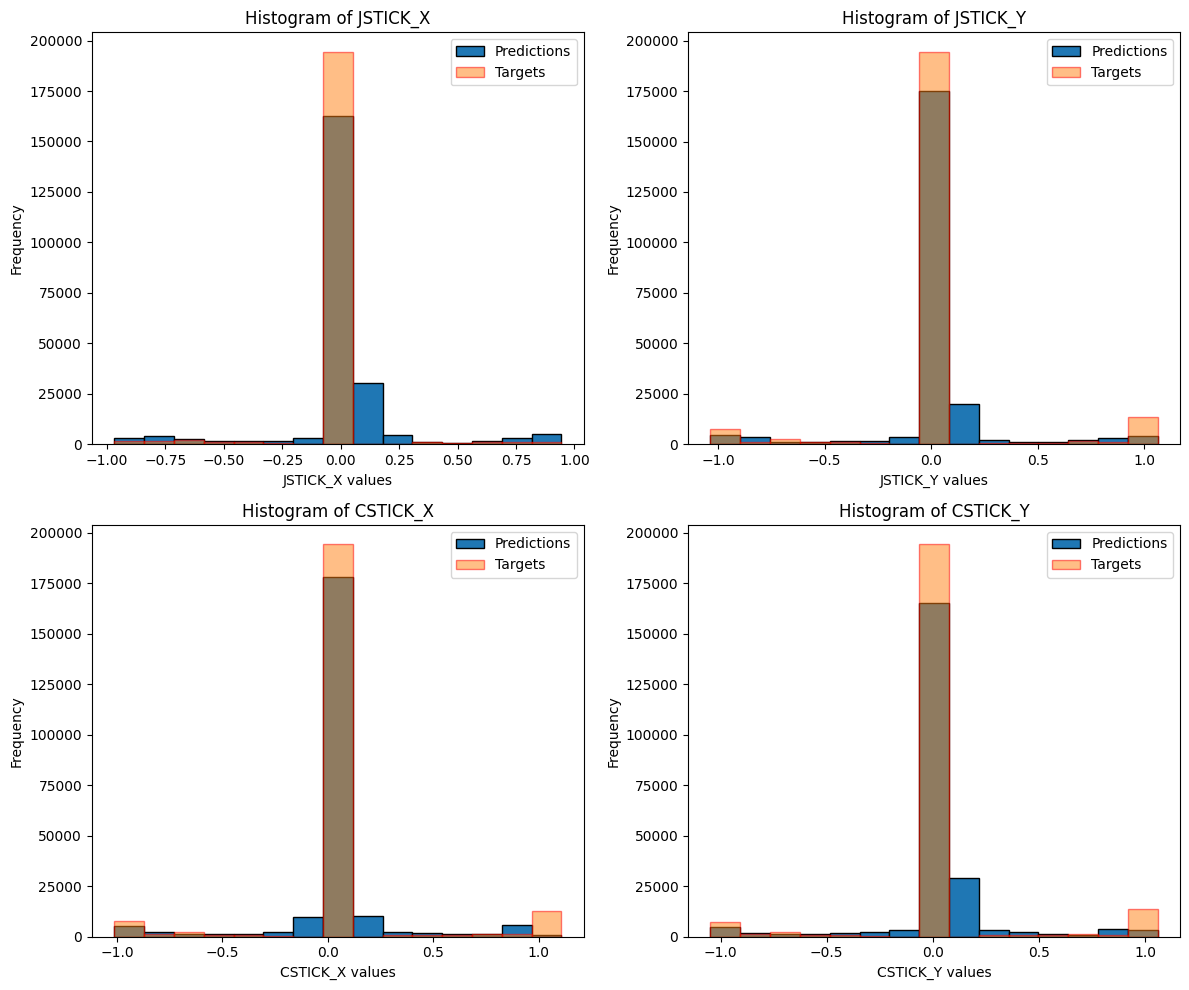

In [89]:
def stick_histograms(predictions, targets, jstick_n_bins, c_stick_n_bins):
    
    # get the max and min of JSTICK_X, JSTICK_Y, CSTICK_X, and CSTICK_Y
    jstick_x_max, jstick_x_min = np.max(predictions[:, :, 0]), np.min(predictions[:, :, 0])
    jstick_y_max, jstick_y_min = np.max(predictions[:, :, 1]), np.min(predictions[:, :, 1])
    cstick_x_max, cstick_x_min = np.max(predictions[:, :, 2]), np.min(predictions[:, :, 2])
    cstick_y_max, cstick_y_min = np.max(predictions[:, :, 3]), np.min(predictions[:, :, 3])
    
    print(f'Predictions JSTICK_X max: {jstick_x_max}, min: {jstick_x_min}')
    print(f'Predictions JSTICK_Y max: {jstick_y_max}, min: {jstick_y_min}')
    print(f'Predictions CSTICK_X max: {cstick_x_max}, min: {cstick_x_min}')
    print(f'Predictions CSTICK_Y max: {cstick_y_max}, min: {cstick_y_min}')
    
    # Histograms
    pred_hist_jstick_x, edges_jstick_x = np.histogram(predictions[:, :, 0], bins=jstick_n_bins, range=(jstick_x_min, jstick_x_max))
    target_hist_jstick_x, _ = np.histogram(targets[:, :, 0], bins=jstick_n_bins, range=(jstick_x_min, jstick_x_max))
    
    pred_hist_jstick_y, edges_jstick_y = np.histogram(predictions[:, :, 1], bins=jstick_n_bins, range=(jstick_y_min, jstick_y_max))
    target_hist_jstick_y, _ = np.histogram(targets[:, :, 1], bins=jstick_n_bins, range=(jstick_y_min, jstick_y_max))
    
    pred_hist_cstick_x, edges_cstick_x = np.histogram(predictions[:, :, 2], bins=c_stick_n_bins, range=(cstick_x_min, cstick_x_max))
    target_hist_cstick_x, _ = np.histogram(targets[:, :, 2], bins=c_stick_n_bins, range=(cstick_x_min, cstick_x_max))
    
    pred_hist_cstick_y, edges_cstick_y = np.histogram(predictions[:, :, 3], bins=c_stick_n_bins, range=(cstick_y_min, cstick_y_max))
    target_hist_cstick_y, _ = np.histogram(targets[:, :, 3], bins=c_stick_n_bins, range=(cstick_y_min, cstick_y_max))
    
    # Plotting histograms
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # JSTICK_X histogram
    axs[0, 0].bar(edges_jstick_x[:-1], pred_hist_jstick_x, width=np.diff(edges_jstick_x), edgecolor="black", align="edge", label='Predictions')
    axs[0, 0].bar(edges_jstick_x[:-1], target_hist_jstick_x, width=np.diff(edges_jstick_x), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[0, 0].legend()
    axs[0, 0].set_title('Histogram of JSTICK_X')
    axs[0, 0].set_xlabel('JSTICK_X values')
    axs[0, 0].set_ylabel('Frequency')
    
    # JSTICK_Y histogram
    axs[0, 1].bar(edges_jstick_y[:-1], pred_hist_jstick_y, width=np.diff(edges_jstick_y), edgecolor="black", align="edge", label='Predictions')
    axs[0, 1].bar(edges_jstick_y[:-1], target_hist_jstick_y, width=np.diff(edges_jstick_y), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[0, 1].legend()
    axs[0, 1].set_title('Histogram of JSTICK_Y')
    axs[0, 1].set_xlabel('JSTICK_Y values')
    axs[0, 1].set_ylabel('Frequency')
    
    # CSTICK_X histogram
    axs[1, 0].bar(edges_cstick_x[:-1], pred_hist_cstick_x, width=np.diff(edges_cstick_x), edgecolor="black", align="edge", label='Predictions')
    axs[1, 0].bar(edges_cstick_x[:-1], target_hist_cstick_x, width=np.diff(edges_cstick_x), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[1, 0].legend()
    axs[1, 0].set_title('Histogram of CSTICK_X')
    axs[1, 0].set_xlabel('CSTICK_X values')
    axs[1, 0].set_ylabel('Frequency')
    
    # CSTICK_Y histogram
    axs[1, 1].bar(edges_cstick_y[:-1], pred_hist_cstick_y, width=np.diff(edges_cstick_y), edgecolor="black", align="edge", label='Predictions')
    axs[1, 1].bar(edges_cstick_y[:-1], target_hist_cstick_y, width=np.diff(edges_cstick_y), edgecolor="red", align="edge", label='Targets', alpha=0.5)
    axs[1, 1].legend()
    axs[1, 1].set_title('Histogram of CSTICK_Y')
    axs[1, 1].set_xlabel('CSTICK_Y values')
    axs[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Example usage
# pred: predictions numpy array of shape (batch_size, 9, 60)
# target: targets numpy array of shape (batch_size, 9, 60)
# Adjust bins as needed
stick_histograms(pred, target, 15, 15)


In [111]:


# def confusion_matricies(predictions, targets, jstick_n_bins, c_stick_n_bins):
    
#     # transformed_predicted_jstick = jstick_n_bins * (np.clip(predictions[:,:1,:],-1,1) + 1)
#     # transformed_predicted_cstick = c_stick_n_bins * (np.clip(predictions[:,1:3,:],-1,1) + 1)
#     # transformed_targets_jstick = jstick_n_bins * (predictions[:,:1,:].copy() + 1)
#     # transformed_targets_cstick = c_stick_n_bins * (predictions[:,1:3,:].copy() + 1)
    
#     jstick_error_bins = np.floor(jstick_n_bins * (predictions[:,:1,:] - targets[:,:1,:] + 2)) + np.floor(jstick_n_bins * (targets[:,:1,:] + 2))   # values can range between (0,2 * jstick_n_bins)
#     bin_of_target_j_stick = np.floor(jstick_n_bins * (targets[:,:1,:] + 2))  # values range between (0,2 * jstick_n_bins)
    
#     # jstick_pred_for_confusion =    jstick_error_bins / (jstick_n_bins) - 2 # values can range between (0,2 * jstick_n_bins)
#     # jstick_target_for_confusion =  bin_of_target_j_stick / (jstick_n_bins) - 2 # values range between (0,2 * jstick_n_bins)
    
#     labels_jstick = np.arange(0, 2 * jstick_n_bins)
#     ConfusionMatrixDisplay.from_predictions(jstick_error_bins.flatten(), bin_of_target_j_stick.flatten(), labels=labels_jstick, sample_weight=None, normalize=None)
#     plt.show()
    
    
    
#     # predicted_binary = np.array(transformed_predictions[:,3:,:] > .5, dtype = np.float32)
#     # targets_binary = targets[:,3:,:]
    
#     # transformed_jstick = predictions.copy
#     # jstick_is_close = np.is_close(predictions[:,:1,:], targets[:,:1,:], atol = jstick_n_bins ** -1)
#     # cstick_is_close = np.is_close(predictions[:,:1,:], targets[:,:1,:], atol = cstick_n_bins ** -1)
    
    
#     # transformed_predictions = jstick_n_bins * (transformed_predictions[:,0:1,:] + 1)

# confusion_matricies(pred, target, 3, 11)

ValueError: At least one label specified must be in y_true

(25000, 60)


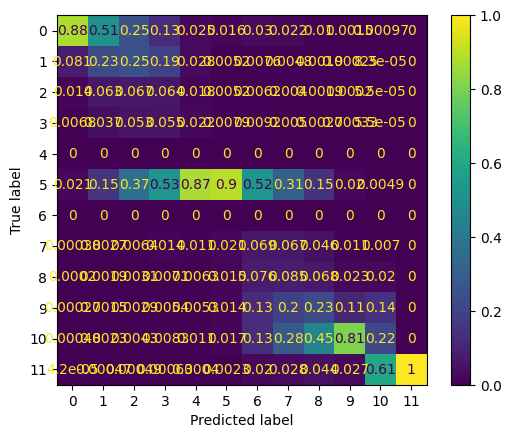

In [133]:

def confusion_matrices(predictions, targets, jstick_n_bins):
    predictions = np.clip(predictions[:,0,:], -1, 1)
    targets = np.clip(targets[:,0,:], -1, 1)
    print(predictions.shape)

    target_bins = np.floor((targets + 1) * jstick_n_bins / 2).astype(int) 
    prediction_adjustment = (predictions - targets)
    prediction_bins = target_bins + np.floor(prediction_adjustment * jstick_n_bins / 2).astype(int)
    prediction_bins = np.clip(prediction_bins, 0, 2 * jstick_n_bins - 1)

    target_bins_flat = target_bins.flatten()
    prediction_bins_flat = prediction_bins.flatten()

    # Determine the actual labels present
    all_labels = np.unique(np.concatenate([target_bins_flat, prediction_bins_flat]))

    # Create confusion matrix
    cm = confusion_matrix(target_bins_flat, prediction_bins_flat, labels=all_labels, normalize='pred')
    ConfusionMatrixDisplay(cm, display_labels=all_labels).plot()
    plt.show()
    
confusion_matrices(pred, target, 11)

In [140]:
def confusion_heatmap_none(predictions, targets, jstick_n_bins):
    # Clip and flatten the predictions and targets
    predictions = np.clip(predictions[:, 0, :], -1, 1).flatten()
    targets = np.clip(targets[:, 0, :], -1, 1).flatten()
    
    # Create a 2D histogram of the data
    heatmap, xedges, yedges = np.histogram2d(predictions, targets, bins=jstick_n_bins, range=[[-1, 1], [-1, 1]])
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))  # Increase figure size
    plt.imshow(heatmap, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    
    # Adding color bar to understand the scale of counts
    plt.colorbar(label='Count')
    
    # Labels for axes
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    
    # Set x and y ticks to represent the edges of bins
    plt.xticks((xedges[:-1] + xedges[1:])/2, labels=[f"{edge:.2f}" for edge in xedges[:-1]])
    plt.yticks((yedges[:-1] + yedges[1:])/2, labels=[f"{edge:.2f}" for edge in yedges[:-1]])
    
    plt.title('Heatmap of Predictions vs Targets')
    plt.show()

def confusion_heatmap_normalize_pred(predictions, targets, jstick_n_bins):
    # Clip and flatten the predictions and targets
    predictions = np.clip(predictions[:, 0, :], -1, 1).flatten()
    targets = np.clip(targets[:, 0, :], -1, 1).flatten()
    
    # Create a 2D histogram of the data
    heatmap, xedges, yedges = np.histogram2d(predictions, targets, bins=jstick_n_bins, range=[[-1, 1], [-1, 1]])
    
    # Plot the heatmap
    plt.figure(figsize=(10, 8))  # Increase figure size
    plt.imshow(heatmap, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    
    # Adding color bar to understand the scale of counts
    plt.colorbar(label='Count')
    
    # Labels for axes
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    
    # Set x and y ticks to represent the edges of bins
    plt.xticks((xedges[:-1] + xedges[1:])/2, labels=[f"{edge:.2f}" for edge in xedges[:-1]])
    plt.yticks((yedges[:-1] + yedges[1:])/2, labels=[f"{edge:.2f}" for edge in yedges[:-1]])
    
    plt.title('Heatmap of Predictions vs Targets')
    plt.show()
    
confusion_heatmap_none(pred, target, 30)

(25000, 60)


ValueError: too many values to unpack (expected 2)

In [ ]:
def confusion_heatmap_none(predictions, targets, jstick_n_bins):
    # Clip and flatten the predictions and targets
    predictions = np.clip(predictions[:, 0, :], -1, 1).flatten()
    targets = np.clip(targets[:, 0, :], -1, 1).flatten()
    
    # Create a 2D histogram of the data
    heatmap, xedges, yedges = np.histogram2d(predictions, targets, bins=jstick_n_bins, range=[[-1, 1], [-1, 1]])
    
    # Plot the heatmap
    plt.figure(figsize=(20,20))  # Increase figure size
    plt.imshow(heatmap, origin='lower', extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    
    # Adding color bar to understand the scale of counts
    plt.colorbar(label='Count')
    
    # Labels for axes
    plt.xlabel('Predictions')
    plt.ylabel('Targets')
    
    # Set x and y ticks to represent the edges of bins
    plt.xticks((xedges[:-1] + xedges[1:])/2, labels=[f"{edge:.2f}" for edge in xedges[:-1]])
    plt.yticks((yedges[:-1] + yedges[1:])/2, labels=[f"{edge:.2f}" for edge in yedges[:-1]])
    
    plt.title('Heatmap of Predictions vs Targets')
    plt.show()
    
    
confusion_heatmap_none(pred, target, 30)